In [40]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
 
from sklearn.tree import plot_tree
 
from sklearn.metrics import (
    f1_score, roc_auc_score, accuracy_score,
    precision_score, recall_score, roc_curve
)

In [3]:

# Load data
df = pd.read_csv('Data/UCI_Credit_Card.csv')
 

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === 1. Load Preprocessed Data ===
X_train = pd.read_csv("data/X_train.csv", index_col=0)
X_val = pd.read_csv("data/X_val.csv", index_col=0)
X_test = pd.read_csv("data/X_test.csv", index_col=0)

# ✅ Read once and correctly as Series
y_train = pd.read_csv("data/y_train.csv", index_col=0)

y_val = pd.read_csv("data/y_val.csv", index_col=0) 
y_test = pd.read_csv("data/y_test.csv", index_col=0) 


print("Loaded shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

 
# === 3. Scale Numeric Columns ===
num_cols = [col for col in X_train.columns if 'BILL_AMT' in col or 'PAY_AMT' in col]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])
 
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()
# Fix zero-column DataFrames by pulling from the index (if the value is stored there)
if y_train.shape[1] == 0:
    y_train = y_train.index.to_series()
    y_val = y_val.index.to_series()
    y_test = y_test.index.to_series()


# === 4. Sanity Check ===
print("\nMean of scaled training features (should be ~0):\n", X_train_scaled[num_cols].mean())
print("\nStd of scaled training features (should be ~1):\n", X_train_scaled[num_cols].std())


Loaded shapes:
X_train: (18000, 22) y_train: (18000, 0)
X_val: (6000, 22) y_val: (6000, 0)
X_test: (6000, 22) y_test: (6000, 0)

Mean of scaled training features (should be ~0):
 BILL_AMT1    1.026340e-17
BILL_AMT2    1.184238e-17
BILL_AMT3    1.934255e-17
BILL_AMT4   -1.144763e-17
BILL_AMT5   -1.223712e-17
BILL_AMT6   -1.539509e-17
PAY_AMT1     7.894919e-19
PAY_AMT2     9.079157e-18
PAY_AMT3    -5.921189e-18
PAY_AMT4     1.065814e-17
PAY_AMT5    -2.171103e-18
PAY_AMT6    -3.552714e-18
dtype: float64

Std of scaled training features (should be ~1):
 BILL_AMT1    1.000028
BILL_AMT2    1.000028
BILL_AMT3    1.000028
BILL_AMT4    1.000028
BILL_AMT5    1.000028
BILL_AMT6    1.000028
PAY_AMT1     1.000028
PAY_AMT2     1.000028
PAY_AMT3     1.000028
PAY_AMT4     1.000028
PAY_AMT5     1.000028
PAY_AMT6     1.000028
dtype: float64


# Decision Tree

In [52]:

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_val)
print("Decision Tree:")
print(confusion_matrix(y_val, dt_preds))
print(classification_report(y_val, dt_preds))


Decision Tree:
[[3788  885]
 [ 776  551]]
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      4673
           1       0.38      0.42      0.40      1327

    accuracy                           0.72      6000
   macro avg       0.61      0.61      0.61      6000
weighted avg       0.73      0.72      0.73      6000



## Hyperpara tuning

In [16]:

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, 
                       cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)

print("Best parameters:", grid_dt.best_params_)
print("Best F1 score from CV:", grid_dt.best_score_)

# Evaluate on validation set
best_dt = grid_dt.best_estimator_
dt_val_preds = best_dt.predict(X_val)
print("Fine-tuned Decision Tree:")
print(classification_report(y_val, dt_val_preds))


Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 score from CV: 0.49095452570480774
Fine-tuned Decision Tree:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.65      0.34      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



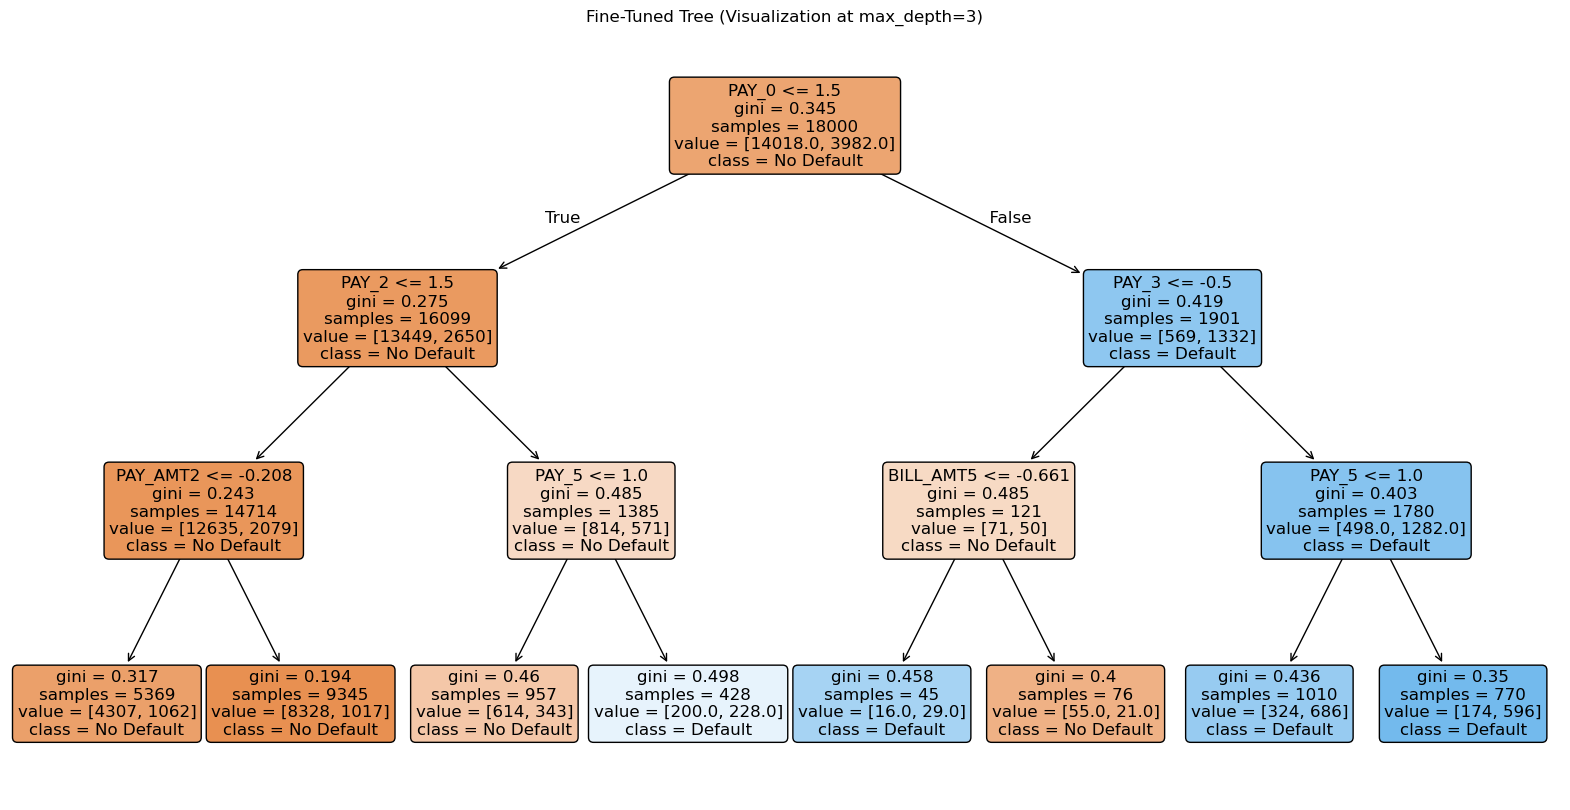

In [17]:
# Use best params, but cap depth for plot
dt_viz = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=best_dt.min_samples_split,
    min_samples_leaf=best_dt.min_samples_leaf,
    random_state=42
)
dt_viz.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt_viz, feature_names=X_train.columns, class_names=["No Default", "Default"],
          filled=True, rounded=True, fontsize=12)
plt.title("Fine-Tuned Tree (Visualization at max_depth=3)")
plt.show()



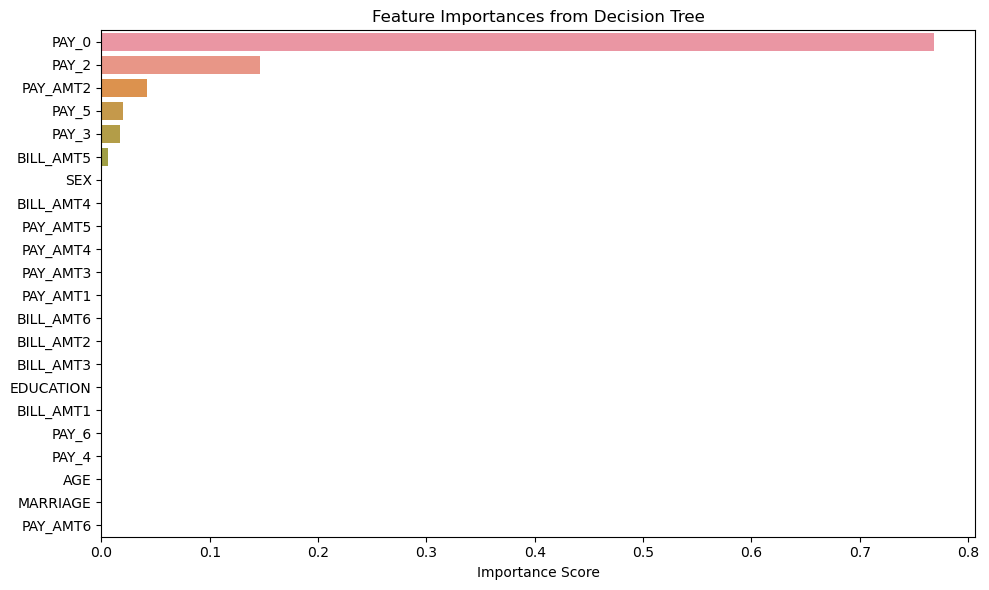

In [18]:
 
importances = best_dt.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title("Feature Importances from Decision Tree")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


## Cost sensitivity tuning


In default prediction, false negatives (failing to detect a default) are usually more costly than false positives (mistakenly flagging someone who wouldn't default). So we want the model to penalize mistakes on defaults more heavily.

In [19]:
 
param_grid = {
    'class_weight': [{0:1, 1:w} for w in [1, 2, 5, 10, 20]],
        'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}
scorer = 'recall'  # or 'f1' or 'roc_auc'

dt = DecisionTreeClassifier(max_depth=5, random_state=42)

grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 5}, {0: 1, 1: 10},
                                          {0: 1, 1: 20}],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='recall')

In [48]:
dt_balanced = DecisionTreeClassifier(
    #class_weight="balanced",
    class_weight={0: 1, 1: 5},
  
    max_depth=3,
    min_samples_split=best_dt.min_samples_split,
    min_samples_leaf=best_dt.min_samples_leaf,
    random_state=42
)

dt_balanced.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_depth=3, random_state=42)

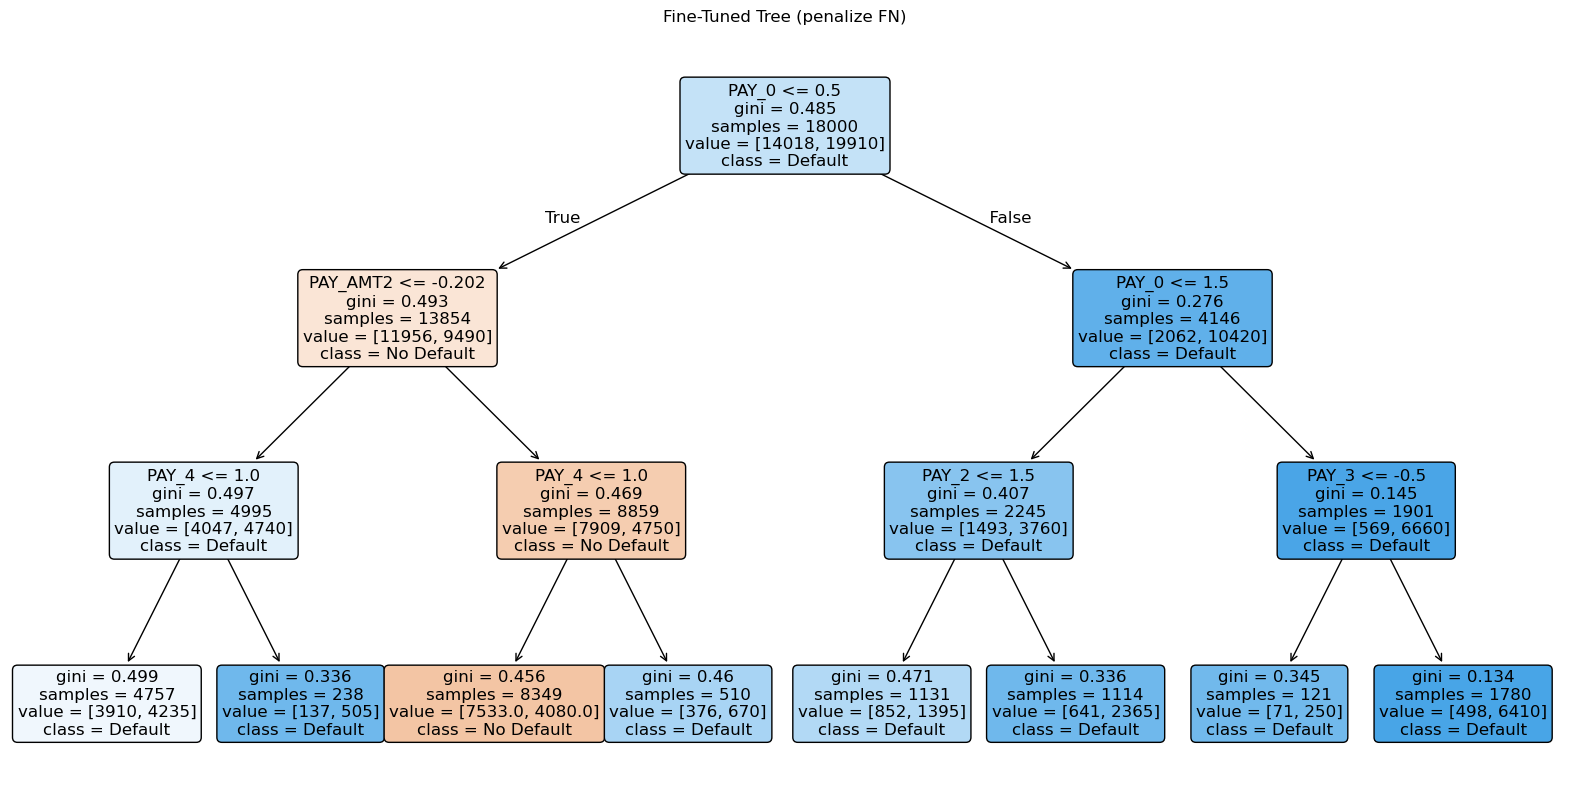

In [49]:

plt.figure(figsize=(20, 10))
plot_tree(dt_balanced , feature_names=X_train.columns, class_names=["No Default", "Default"],
          filled=True, rounded=True, fontsize=12)
plt.title("Fine-Tuned Tree (penalize FN)")
plt.show()


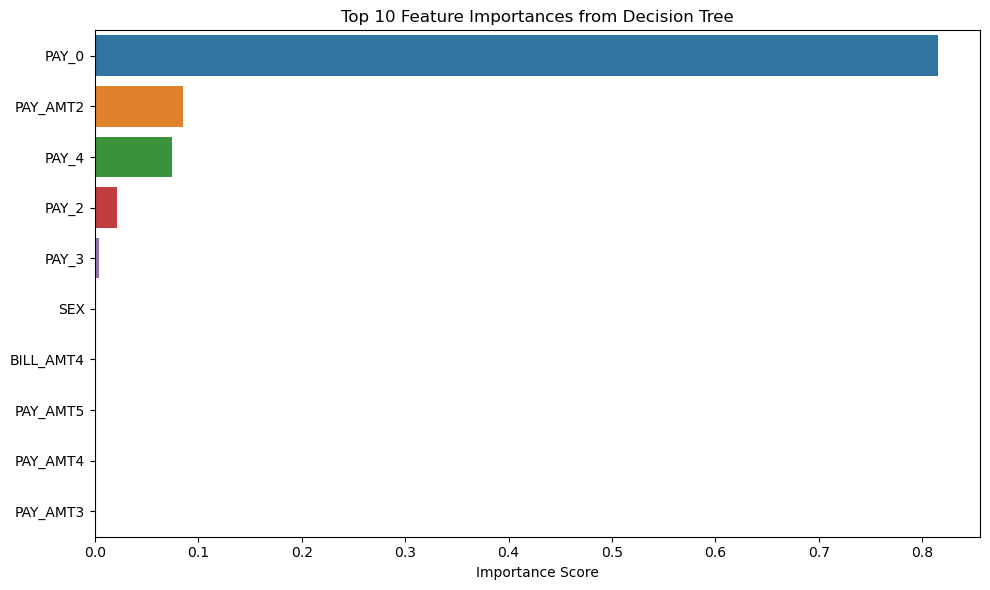

In [56]:
importances = dt_balanced.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

# Select top 10 features
top_10 = feat_importance.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10.values, y=top_10.index)
plt.title("Top 10 Feature Importances from Decision Tree")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


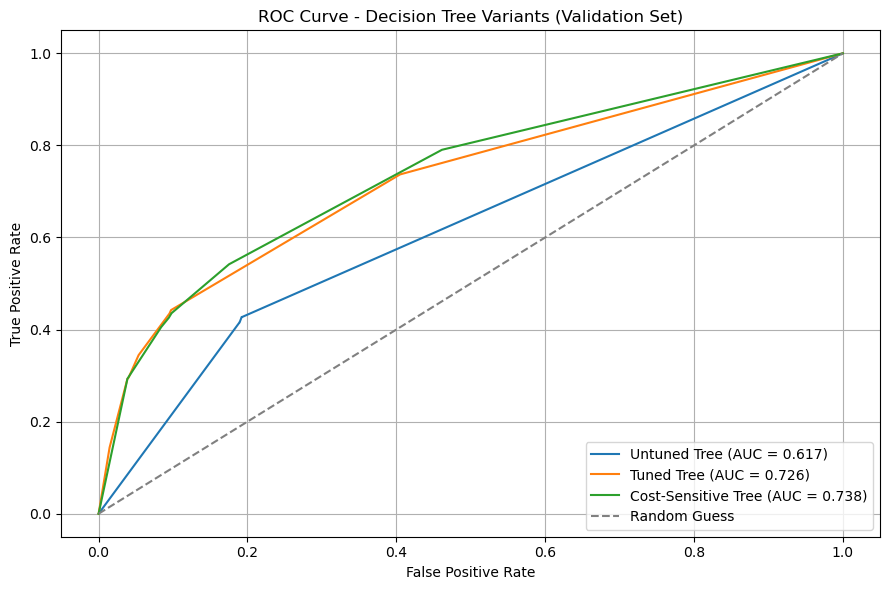

In [54]:
 
# Predict validation probabilities
probs_dt = dt.predict_proba(X_val_scaled)[:, 1]
probs_viz = dt_viz.predict_proba(X_val_scaled)[:, 1]
probs_bal = dt_balanced.predict_proba(X_val_scaled)[:, 1]

# Compute ROC + AUC
fpr_dt, tpr_dt, _ = roc_curve(y_val, probs_dt)
auc_dt = roc_auc_score(y_val, probs_dt)

fpr_viz, tpr_viz, _ = roc_curve(y_val, probs_viz)
auc_viz = roc_auc_score(y_val, probs_viz)

fpr_bal, tpr_bal, _ = roc_curve(y_val, probs_bal)
auc_bal = roc_auc_score(y_val, probs_bal)

# Plot ROC curves
plt.figure(figsize=(9, 6))
plt.plot(fpr_dt, tpr_dt, label=f"Untuned Tree (AUC = {auc_dt:.3f})")
plt.plot(fpr_viz, tpr_viz, label=f"Tuned Tree (AUC = {auc_viz:.3f})")
plt.plot(fpr_bal, tpr_bal, label=f"Cost-Sensitive Tree (AUC = {auc_bal:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")

plt.title("ROC Curve - Decision Tree Variants (Validation Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


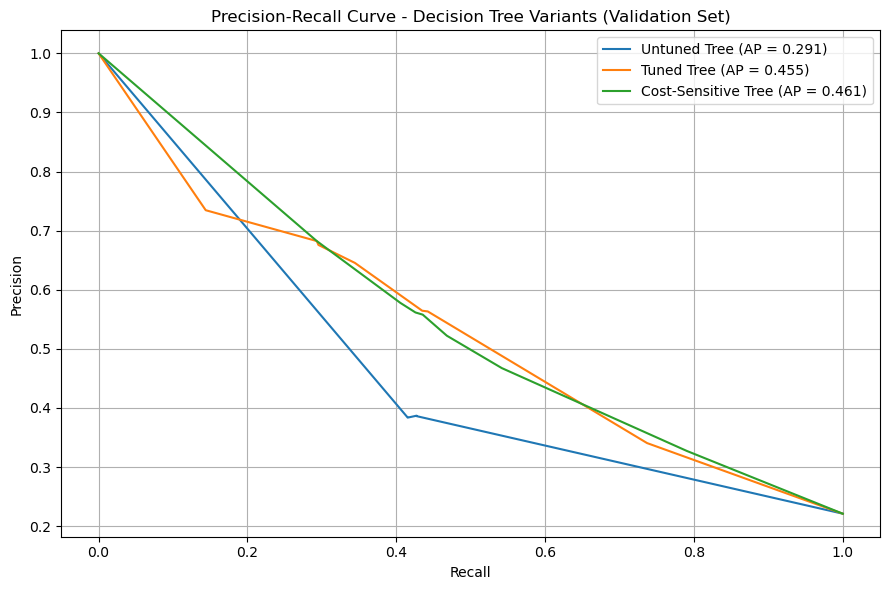

In [55]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Compute precision, recall, and average precision for each model
precision_dt, recall_dt, _ = precision_recall_curve(y_val, probs_dt)
ap_dt = average_precision_score(y_val, probs_dt)

precision_viz, recall_viz, _ = precision_recall_curve(y_val, probs_viz)
ap_viz = average_precision_score(y_val, probs_viz)

precision_bal, recall_bal, _ = precision_recall_curve(y_val, probs_bal)
ap_bal = average_precision_score(y_val, probs_bal)

# Plot Precision-Recall curves
plt.figure(figsize=(9, 6))
plt.plot(recall_dt, precision_dt, label=f"Untuned Tree (AP = {ap_dt:.3f})")
plt.plot(recall_viz, precision_viz, label=f"Tuned Tree (AP = {ap_viz:.3f})")
plt.plot(recall_bal, precision_bal, label=f"Cost-Sensitive Tree (AP = {ap_bal:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Decision Tree Variants (Validation Set)")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Random Forest

In [27]:

# 2. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)
print("Random Forest:")
print(confusion_matrix(y_val, rf_preds))
print(classification_report(y_val, rf_preds))




Random Forest:
[[4390  283]
 [ 873  454]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4673
           1       0.62      0.34      0.44      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000



hyperpara tuning

In [28]:
 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='recall',  # or 'roc_auc', 'f1'
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
print("Best params:", grid_rf.best_params_)


Best params: {'class_weight': {0: 1, 1: 10}, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [30]:
rf_preds_grid = grid_rf.predict(X_val)
print("Random Forest:")
print(confusion_matrix(y_val, rf_preds_grid))
print(classification_report(y_val, rf_preds_grid)) 


Random Forest:
[[ 488 4185]
 [  20 1307]]
              precision    recall  f1-score   support

           0       0.96      0.10      0.19      4673
           1       0.24      0.98      0.38      1327

    accuracy                           0.30      6000
   macro avg       0.60      0.54      0.29      6000
weighted avg       0.80      0.30      0.23      6000



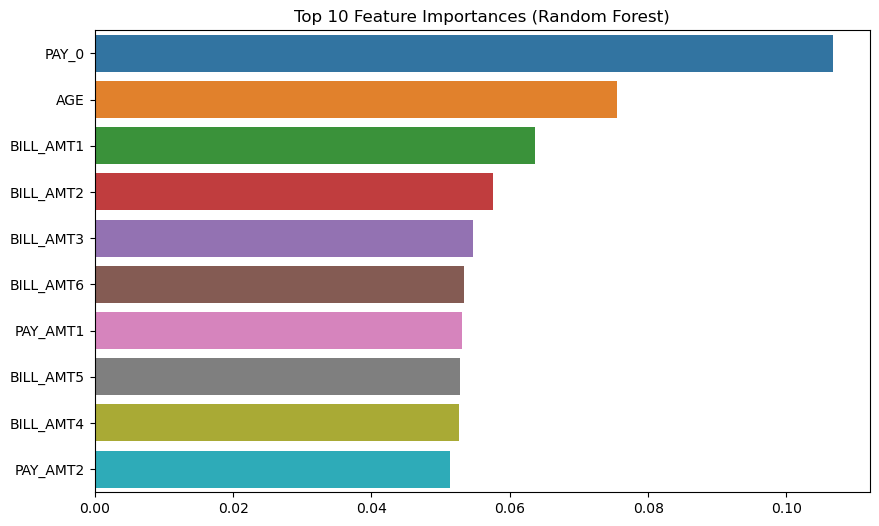

In [31]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

# Gradient boosting

In [34]:


# Define GBM grid
param_grid_gbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1]
}

# Grid search for GBM
grid_gbm = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gbm,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_gbm.fit(X_train, y_train)

# Best model from GridSearchCV
best_gbm = grid_gbm.best_estimator_
gbm_preds = best_gbm.predict(X_val)

print("Tuned Gradient Boosting:")
print(confusion_matrix(y_val, gbm_preds))
print(classification_report(y_val, gbm_preds))


Tuned Gradient Boosting:
[[4420  253]
 [ 878  449]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4673
           1       0.64      0.34      0.44      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000



In [35]:
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)

# Evaluate on validation set
best_xgb = grid_xgb.best_estimator_
xgb_preds = best_xgb.predict(X_val)

print("Tuned XGBoost:")
print(confusion_matrix(y_val, xgb_preds))
print(classification_report(y_val, xgb_preds))


/Users/yb/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yb/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yb/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yb/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update

Tuned XGBoost:
[[4437  236]
 [ 878  449]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4673
           1       0.66      0.34      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.64      0.67      6000
weighted avg       0.80      0.81      0.79      6000



/Users/yb/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:02:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


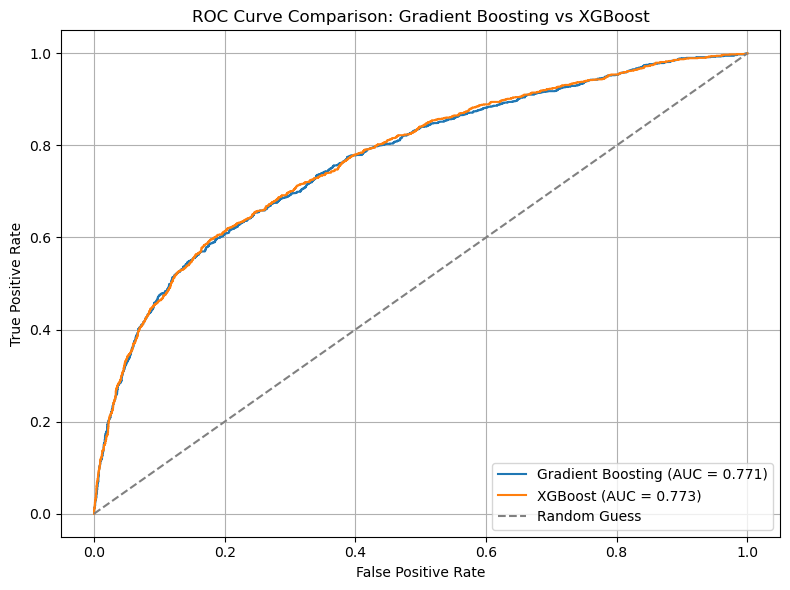

In [36]:
 
# Get predicted probabilities
gbm_probs = best_gbm.predict_proba(X_val)[:, 1]
xgb_probs = best_xgb.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr_gbm, tpr_gbm, _ = roc_curve(y_val, gbm_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, xgb_probs)
auc_gbm = roc_auc_score(y_val, gbm_probs)
auc_xgb = roc_auc_score(y_val, xgb_probs)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_gbm, tpr_gbm, label=f"Gradient Boosting (AUC = {auc_gbm:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")

plt.title("ROC Curve Comparison: Gradient Boosting vs XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Overall comparism


In [38]:
from sklearn.metrics import f1_score, roc_auc_score

# Predict class labels and probabilities
dt_best_preds = best_dt.predict(X_val_scaled)
dt_best_probs = best_dt.predict_proba(X_val_scaled)[:, 1]

dt_cost_preds = dt_balanced.predict(X_val_scaled)
dt_cost_probs = dt_balanced.predict_proba(X_val_scaled)[:, 1]

rf_preds = grid_rf.predict(X_val_scaled)
rf_probs = grid_rf.predict_proba(X_val_scaled)[:, 1]

xgb_preds = best_xgb.predict(X_val_scaled)
xgb_probs = best_xgb.predict_proba(X_val_scaled)[:, 1]

# Compute metrics
summary = pd.DataFrame({
    "Model": [
        "Tuned Decision Tree",
        "Cost-Sensitive Tree",
        "Tuned Random Forest",
        "Tuned XGBoost"
    ],
    "AUC (Validation Set)": [
        roc_auc_score(y_val, dt_best_probs),
        roc_auc_score(y_val, dt_cost_probs),
        roc_auc_score(y_val, rf_probs),
        roc_auc_score(y_val, xgb_probs)
    ],
    "F1 Score": [
        f1_score(y_val, dt_best_preds),
        f1_score(y_val, dt_cost_preds),
        f1_score(y_val, rf_preds),
        f1_score(y_val, xgb_preds)
    ]
})

print(summary)


                 Model  AUC (Validation Set)  F1 Score
0  Tuned Decision Tree              0.726302  0.449140
1  Cost-Sensitive Tree              0.726302  0.449140
2  Tuned Random Forest              0.764932  0.383341
3        Tuned XGBoost              0.773272  0.446322


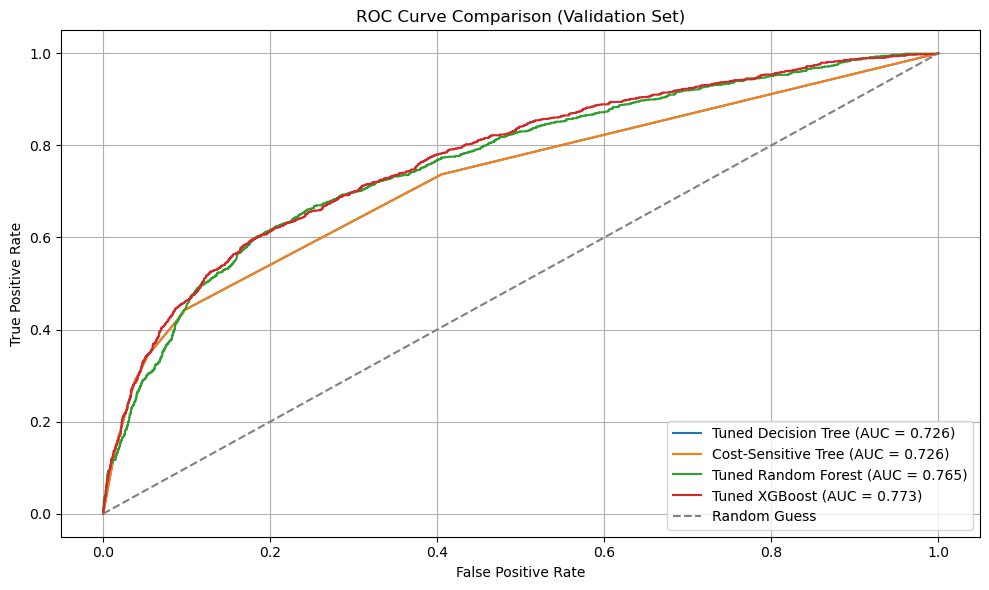

                 Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Tuned Decision Tree  0.813167   0.645480  0.344386  0.449140  0.726302
1  Cost-Sensitive Tree  0.813167   0.645480  0.344386  0.449140  0.726302
3        Tuned XGBoost  0.814333   0.655474  0.338357  0.446322  0.773272
2  Tuned Random Forest  0.299167   0.237983  0.984928  0.383341  0.764932


In [41]:
 
# 1. Predict for all models
preds_probs = {
    "Tuned Decision Tree": (best_dt.predict(X_val_scaled), best_dt.predict_proba(X_val_scaled)[:, 1]),
    "Cost-Sensitive Tree": (dt_balanced.predict(X_val_scaled), dt_balanced.predict_proba(X_val_scaled)[:, 1]),
    "Tuned Random Forest": (grid_rf.predict(X_val_scaled), grid_rf.predict_proba(X_val_scaled)[:, 1]),
    "Tuned XGBoost": (best_xgb.predict(X_val_scaled), best_xgb.predict_proba(X_val_scaled)[:, 1]),
}

# 2. Collect metrics + plot ROC
results = []
plt.figure(figsize=(10, 6))

for name, (y_pred, y_prob) in preds_probs.items():
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc
    })

# 3. Finalize ROC plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Validation Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Summary Table
summary_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print(summary_df)
